# 네이버 영화리뷰 감성분석  
  
  
### 1) 데이터 준비와 확인
네이버 영화의 댓글을 모아 구성된 한국어 텍스트 감성 분석  
Naver sentiment movie corpus Link: https://github.com/e9t/nsmc

In [8]:
import pandas as pd

from konlpy.tag import Mecab
import numpy as np
from collections import Counter

from tensorflow import keras
import tensorflow as tf
import os

import matplotlib.pyplot as plt

from gensim.models.keyedvectors import Word2VecKeyedVectors

from gensim.models import KeyedVectors

from tensorflow.keras.initializers import Constant
import pprint

import gensim
import gensim.models

In [9]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2) 데이터로더 구성  
  
전혀 가공되지 않은 nsmc 데이터셋 텍스트 파일을 읽어 data_loader 생성  
  
**data_loader 안에서 수행해야할 사항**  
-데이터의 중복 제거  
-NaN 결측치 제거  
-한국어 토크나이저로 토큰화  
-불용어(Stopwords) 제거  
-사전 word_to_index 구성  
-텍스트 스트링을 사전 인덱스 스트링으로 변환  
-X_train, y_train, X_test, y_test, word_to_index 리턴  

In [10]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]  #인덱스 정의
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]  #unknown으로 반환
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [11]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [12]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3) 모델 구성을 위한 데이터 분석 및 가공
-데이터셋 내 문장 길이 분포  
-적절한 최대 문장 길이 지정  
-keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [13]:
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))


# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens) # 최대 길이
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [14]:
#keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가 (pre)
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

### 4) 모델 구성 및 validation set 구성  
  
  
# 1. RNN모델  

In [15]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


**validation set 구성**  
훈련용 데이터셋 25000건 중 10000건을 분리하여 검증셋(validation set)으로 사용

In [16]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


### 5) 모델 훈련 개시
**RNN 모델학습 시작**

In [17]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 5s 7ms/step - loss: 0.4870 - accuracy: 0.7864 - val_loss: 0.3591 - val_accuracy: 0.8460
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3426 - accuracy: 0.8549 - val_loss: 0.3462 - val_accuracy: 0.8507
Epoch 3/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3219 - accuracy: 0.8659 - val_loss: 0.3441 - val_accuracy: 0.8504
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3115 - accuracy: 0.8701 - val_loss: 0.3425 - val_accuracy: 0.8536
Epoch 5/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3038 - accuracy: 0.8738 - val_loss: 0.3467 - val_accuracy: 0.8491
Epoch 6/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2959 - accuracy: 0.8776 - val_loss: 0.3419 - val_accuracy: 0.8533
Epoch 7/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2875 - accuracy: 0.8821 - val_loss: 0.3452 - val_accuracy: 0.8539
Epoch 

**RNN 모델 평가**

In [18]:
#학습이 끝난 모델을 테스트셋으로 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4142 - accuracy: 0.8449
[0.41421130299568176, 0.8449254631996155]


### 6) Loss, Accuracy 그래프 시각화

In [19]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


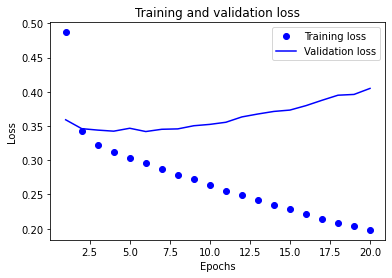

In [20]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

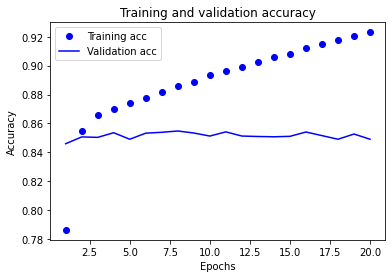

In [21]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 7) 학습된 Embedding 레이어 분석

In [22]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [25]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_rnn.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [26]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [27]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재미']
vector

array([-0.00069379,  0.22808583, -0.16926862,  0.08037532, -0.11409477,
        0.09857723,  0.12837653, -0.04662998,  0.19966602, -0.10589195,
        0.0514828 , -0.0787826 ,  0.01858436, -0.2778194 ,  0.07645588,
       -0.14497097], dtype=float32)

In [28]:
word_vectors.similar_by_word("재미")

[('거의', 0.8610961437225342),
 ('넘', 0.8603217005729675),
 ('특색', 0.8402466773986816),
 ('신비', 0.835227370262146),
 ('공감', 0.821881115436554),
 ('너무', 0.8206154108047485),
 ('몰입', 0.81717848777771),
 ('모두', 0.811876654624939),
 ('듯이', 0.8064684271812439),
 ('완전', 0.7968534231185913)]

# 2. 1-D Convolution Neural Network(1-D CNN)모델

In [29]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

**validation set 구성**  
훈련용 데이터셋 25000건 중 10000건을 분리하여 검증셋(validation set)으로 사용

In [30]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


### 5) 모델 훈련 개시
**CNN 모델학습 시작**

In [31]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 3s 5ms/step - loss: 0.4780 - accuracy: 0.7634 - val_loss: 0.3433 - val_accuracy: 0.8513
Epoch 2/20
266/266 [==============================] - 1s 4ms/step - loss: 0.3234 - accuracy: 0.8623 - val_loss: 0.3322 - val_accuracy: 0.8567
Epoch 3/20
266/266 [==============================] - 1s 4ms/step - loss: 0.2903 - accuracy: 0.8789 - val_loss: 0.3301 - val_accuracy: 0.8595
Epoch 4/20
266/266 [==============================] - 1s 4ms/step - loss: 0.2626 - accuracy: 0.8933 - val_loss: 0.3391 - val_accuracy: 0.8555
Epoch 5/20
266/266 [==============================] - 1s 4ms/step - loss: 0.2330 - accuracy: 0.9080 - val_loss: 0.3529 - val_accuracy: 0.8548
Epoch 6/20
266/266 [==============================] - 1s 4ms/step - loss: 0.2022 - accuracy: 0.9230 - val_loss: 0.3753 - val_accuracy: 0.8519
Epoch 7/20
266/266 [==============================] - 1s 4ms/step - loss: 0.1740 - accuracy: 0.9356 - val_loss: 0.4065 - val_accuracy: 0.8480
Epoch 

**CNN 모델 평가**

In [32]:
#학습이 끝난 모델을 테스트셋으로 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 1.0877 - accuracy: 0.8165
[1.0876952409744263, 0.8164859414100647]


### 6) Loss, Accuracy 그래프 시각화

In [33]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


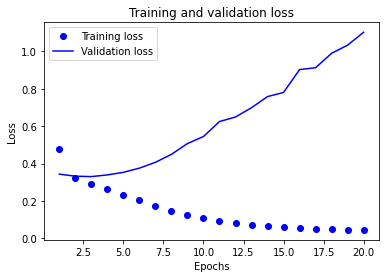

In [34]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

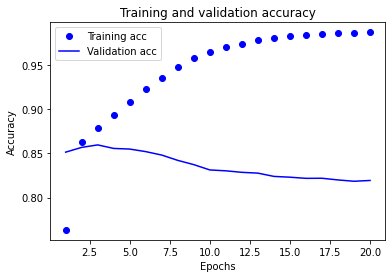

In [35]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 7) 학습된 Embedding 레이어 분석

In [36]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [37]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_cnn.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [38]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [39]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재미']
vector

array([-0.02888467,  0.03305136,  0.02517097, -0.0268227 ,  0.0370813 ,
        0.05058338, -0.07904268, -0.20822127,  0.02407169, -0.12842059,
        0.02391946,  0.10998525,  0.0985043 , -0.07083098,  0.13554148,
       -0.01094636], dtype=float32)

In [40]:
word_vectors.similar_by_word("재미")

[('정무문', 0.7942072153091431),
 ('예수', 0.7695077061653137),
 ('들어도', 0.7414731979370117),
 ('냉전', 0.7213309407234192),
 ('확실히', 0.7195172309875488),
 ('콜린퍼스', 0.716174304485321),
 ('넘', 0.7133120894432068),
 ('폭풍', 0.7101947665214539),
 ('스텝업', 0.6990610361099243),
 ('클리프', 0.697115421295166)]

# 3. GlobalMaxPooling1D() 모델

In [41]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


**validation set 구성**  
훈련용 데이터셋 25000건 중 10000건을 분리하여 검증셋(validation set)으로 사용

In [42]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


### 5) 모델 훈련 개시
**GMP 학습 시작**

In [43]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 1s 4ms/step - loss: 0.5886 - accuracy: 0.7459 - val_loss: 0.4348 - val_accuracy: 0.8079
Epoch 2/20
266/266 [==============================] - 1s 3ms/step - loss: 0.3861 - accuracy: 0.8306 - val_loss: 0.3662 - val_accuracy: 0.8363
Epoch 3/20
266/266 [==============================] - 1s 3ms/step - loss: 0.3369 - accuracy: 0.8557 - val_loss: 0.3532 - val_accuracy: 0.8416
Epoch 4/20
266/266 [==============================] - 1s 3ms/step - loss: 0.3107 - accuracy: 0.8687 - val_loss: 0.3507 - val_accuracy: 0.8447
Epoch 5/20
266/266 [==============================] - 1s 3ms/step - loss: 0.2919 - accuracy: 0.8783 - val_loss: 0.3529 - val_accuracy: 0.8456
Epoch 6/20
266/266 [==============================] - 1s 3ms/step - loss: 0.2773 - accuracy: 0.8857 - val_loss: 0.3568 - val_accuracy: 0.8458
Epoch 7/20
266/266 [==============================] - 1s 3ms/step - loss: 0.2651 - accuracy: 0.8913 - val_loss: 0.3626 - val_accuracy: 0.8468
Epoch 

**GMP 평가**

In [44]:
#학습이 끝난 모델을 테스트셋으로 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4790 - accuracy: 0.8322
[0.47904103994369507, 0.8321703672409058]


### 6) Loss, Accuracy 그래프 시각화

In [45]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


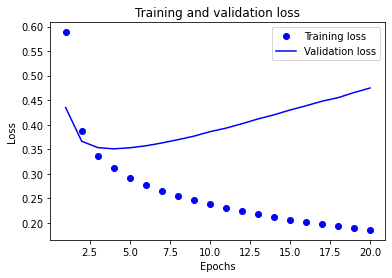

In [46]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

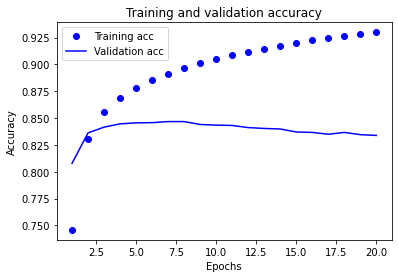

In [47]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 7) 학습된 Embedding 레이어 분석

In [48]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [49]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_gmp.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [50]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [51]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재미']
vector

array([-0.02716972, -0.14069444, -0.00607205, -0.22184633, -0.32154658,
       -0.27684543, -0.03387519, -0.1538319 , -0.25036922, -0.22971706,
       -0.17429683, -0.11242203, -0.08860856,  0.01486629,  0.06705485,
       -0.17510216], dtype=float32)

In [52]:
word_vectors.similar_by_word("재미")

[('박보영', 0.9381862282752991),
 ('가져다', 0.9326872229576111),
 ('성장', 0.9263970851898193),
 ('독립', 0.9192556142807007),
 ('로빈', 0.9155206680297852),
 ('만든', 0.9085784554481506),
 ('극도', 0.9080103635787964),
 ('나았', 0.8992154598236084),
 ('그', 0.8960434198379517),
 ('미사', 0.891055166721344)]

### 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [53]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin' 
word2vec = gensim.models.Word2Vec.load(word2vec_path)

In [54]:
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
word2vec.similar_by_word("재미")

/tmp/ipykernel_5055/1072433422.py:2: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("재미")


[('취미', 0.5857348442077637),
 ('유머', 0.5140613913536072),
 ('매력', 0.5105490684509277),
 ('흥미', 0.4988338351249695),
 ('공짜', 0.4960595667362213),
 ('일자리', 0.49294644594192505),
 ('즐거움', 0.48700767755508423),
 ('비애', 0.4836210310459137),
 ('관객', 0.48286449909210205),
 ('향수', 0.4823310971260071)]

In [56]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_5055/1324384006.py:9: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_5055/1324384006.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [89]:
#LSTM 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  #카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   #trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 2,168,577
Trainable params: 2,168,577
Non-trainable params: 0
_________________________________________________________________


In [90]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
2128/2128 [==============================] - 13s 6ms/step - loss: 0.3798 - accuracy: 0.8269 - val_loss: 0.3135 - val_accuracy: 0.8647
Epoch 2/20
2128/2128 [==============================] - 12s 5ms/step - loss: 0.2828 - accuracy: 0.8808 - val_loss: 0.3006 - val_accuracy: 0.8710
Epoch 3/20
2128/2128 [==============================] - 12s 5ms/step - loss: 0.2390 - accuracy: 0.9018 - val_loss: 0.3067 - val_accuracy: 0.8766
Epoch 4/20
2128/2128 [==============================] - 12s 5ms/step - loss: 0.1987 - accuracy: 0.9198 - val_loss: 0.3184 - val_accuracy: 0.8684
Epoch 5/20
2128/2128 [==============================] - 12s 6ms/step - loss: 0.1587 - accuracy: 0.9379 - val_loss: 0.3530 - val_accuracy: 0.8692
Epoch 6/20
2128/2128 [==============================] - 12s 6ms/step - loss: 0.1213 - accuracy: 0.9542 - val_loss: 0.4004 - val_accuracy: 0.8645
Epoch 7/20
2128/2128 [==============================] - 12s 5ms/step - loss: 0.0918 - accuracy: 0.9670 - val_loss: 0.4634 - val_ac

In [91]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


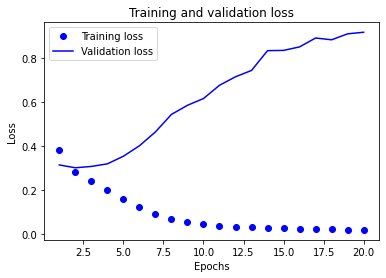

In [92]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

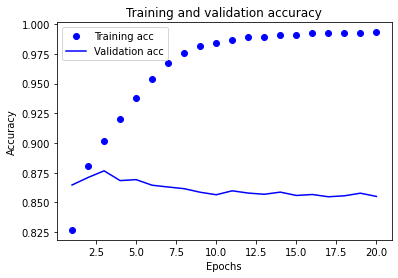

In [93]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [94]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.9054 - accuracy: 0.8522
[0.9053950905799866, 0.852228581905365]


# Exploration 6 회고
  
  
### 3가지 모델 구현 결과  
RNN 모델 : 0.8449  
1-D Convolution Neural Network(1-D CNN)모델 : 0.8165  
GlobalMaxPooling1D() : 0.8322  
  
3가지 모델 중 **가장 성능이 좋은 모델은 RNN모델**이었다. 거의 85%에 가까운 정확도를 보여주었다.  
  
  
  
  
### 한국어 Word2Vec을 활용한 LSTM 모델  
**85%의 정확도를 위해 시도**  
1차 : LSTM(8), epochs=20, batch_size=512 = 0.8319  
2차 : LSTM(8), epochs=10, batch_size=512 = 0.8276  
3차 : LSTM(8), epochs=5, batch_size=512 = 0.8240 
  --> epochs 문제가 아니란 것을 확인, epochs 20의 정확도가 가장 높으니 20으로 진행  
4차 : LSTM(8), epochs=20, batch_size=128 = 0.8260  
5차 : LSTM(8), epochs=20, batch_size=64 = 0.8279  
  --> batch_size 또한 정확도를 올리는데에 크게 기여하지 않음, 64의 정확도가 더 높으니 64로 진행  
6차 : LSTM(128), epochs=20, batch_size=64 = 0.8522  
  --> 모델 구성시 LSTM의 값을 128로 올려주었더니 정확도 향상. **최종 85.2%의 정확도**를 보여 가시적인 성능 향상을 달성했다.  
  
  
  
  
### 항상 역대급 역대급 힘들다고 하는데, 이번 프로젝트가 역대급으로 힘들었다. 힘들었던 점 모음
  
  
**(1) 라이브러리 import**  
보통 실습 후 프로젝트를 진행 할 때, 앞서 진행한 LMS실습에서 사용한 라이브러리를 그대로 참고하여 사용하는데, 이번 프로젝트는 앞선 lms실습에서 사용하지 않았는데 필요한 라이브러리가 많았다. 가령 tf.keras였는데 이건 keras라서 새로 import해야된다던가...하는 자잘자잘한 import 덕분에 인터넷 서치 능력이 향상되었다 ㅋㅋ. 항상 라이브러리 import는 스스로 해보지 않았는데, 이번 기회에 슬슬 라이브러리 서치해서 넣고 하는 경험도 나쁘지 않았다.  



**(2) 데이터로더 구성**  
주어진 예시답안을 그대로 사용하는 줄 알고 패딩을 추가하는데, 자꾸  value=word_to_index"PAD"라는 오류가 났다. 알고보니 PAD, BOS, UNK, UNUSED가 안들어가 있었던 것. 실습에서는 word_to_index "PAD" = 0, word_to_index "BOS" = 1, word_to_index"UNK>" = 2로 하나씩 지정해줬는데, 따로 데이터로더 밑에다가 새로 지정을 해야하는지 유심히 찾다가, vocab안이 비어있는 것을 발견했다. 그래서 vocab = 'PAD', 'BOS', 'UNK', 'UNUSED']으로 안에 넣어줬는데 이렇게 하는게 맞는건지 .. 그리고 word_to_index에 넣는 것과 같은 의미로 사용되는지 의심스럽지만 오류가 나지 않기에 그대로 진행했다.(괜히 예시로 준거 밑에 새로 만들면 오류뜰까봐 무서웠는데 역시나 하나하나 지정해주니까 오류가뜨길래 하지 않았다 .. ㅎㅎ 내 생각에는 word_to_index 지정 후 뒤에 저거 말고 더 필요한게 있는데 내가 못 찾는 느낌)  
    
    
    
**(3) 3가지 모델 구현**  
모델 구성 및 validation set 구성부터 모델을 3가지로 나누었는데, 처음에는 모델 3개를 다 만들어 놓고 그 다음 순서인 모델 훈련이랑 시각화 임베딩까지 진행했다. 모델을 3개를 한번에 훈련 시각화 임베딩을 진행하다보니 구분이 안되서 다 같은 값이 도출되었다. 그래서 model을 각각 rnn,cnn,gmp로 다 바꿔서 rnn.add 이런식으로 했는데, 뭘 잘못했는지 자꾸 오류가 났다 .. 마지막으로 그냥 한개씩 하자 싶어 모델별로 한 번에 훈련, 시각화, 임베딩을 진행하니 각각의 값이 제대로 도출되었다. 이 과정을 수행해보는데 시간이 많이 걸렸지만 결국에 각각 다른 값으로 잘 도출되어 다행이었다.  
    
    
    
**(4) 한국어 Word2Vec 임베딩 활용하여 성능 개선**  
이 프로젝트는 한국어 Word2Vec 임베딩 활용하여 성능 개선 때문에 시간이 가장 오래 걸리고 힘들었다고 해도 과언이 아니다.
  
첫 번째로, word2vec = gensim.models.Word2Vec.load(word2vec_path) 을 하는데 자꾸 AttributeError : Can't get attribute 'Vocabb' on (module 'gensim.models.word2vec' from ~ 라는 오류가 발생했다. 찾아본 결과, gensim의 버전이 4.0이 아닌 3.n으로 해야 오류가 나지 않는 다는 것을 발견했다.(이 부분은 프로젝트 루브릭에도 작성되어있어, 금방 진행 할 수 있었다.)  
  
문제는 지금부터였다. gensim의 버전을 4.0에서 3.n으로 낮추려고 pip install --upgrade gensim==3.8.3을 진행하는데 사진과 같은 알 수 없는 Warning이 발생했다.  
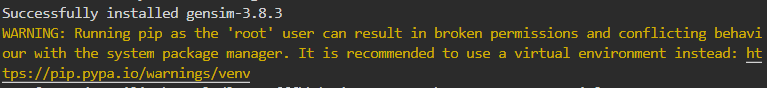  
아무리 찾아봐도 남들은 다 3.n으로 바꾸면 해결된다는 문제를 해결하지 못하고, 온갖 검색식을 동원해 가상환경으로 설치해야 한다는 점을 알아냈다. 결국 다양한 시도 끝에,     $ conda uninstall gensim / $ conda install gensim==3.4.0으로 해결되었다. 하지만 아직까지 더 정확한 해결 방법을 알고싶었는데 알지 못해서 찝찝하다. 가상환경에 대해 좀 더 공부해볼 필요가 있을 듯 했다.  
  
마지막으로, 이전과 같이 word_vector_dim = 300으로 설정해주었는데, Eager execution of tf.constant with unsupported shape (value has 2000000 elements, shape is (10000, 300) with 3000000 elements)라는 오류가 발생했다. 위 오류는 200으로 수정하니 해결되었지만, 아직까지 오류에 대한 이해가 되지 않는다.  
  
  
  
  
지난 익스5도 그렇고 나는 자연어처리에 약한가 싶다 .. 그냥 이 분야가 어려운거겠지? 라는 행복회로 ㅠ 아무튼 정확도를 85%까지 올리게 되어 이정도면 나는 엄청나게 만족한다. 아예 한국어 Word2Vec도 오류난 상태로 제출해야 되겠다고 생각했었으니까 .. 프로젝트들은 할 때는 힘든데 오류를 해결하고 알아내는 과정에서 뭔가 작은 희열이 온다. 아무튼 회고 쓸 힘도 없을 만큼 힘들었는데 이번 프로젝트는 안풀리던 실마리가 해결되서 그런지 쓸 말이 많다. 다음 익스도 화이팅 =)  
  
  
  
---
2022-01-27